This code will use the parameters which were trained using gridsearch separately. Using those parameters, we will train the mlp model on the following processed diabetes datasets:

1. diabetes_012_health_indicators_BRFSS2015.csv
2. diabetes_binary_5050split_health_indicators_BRFSS2015.csv

After the training of the model we will explore the following metrics on the test dataset:

1. classification_report
2. confusion_matrix (heatmap)
3. ROC Curve (only for 5050 binary split dataset)

In [1]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import numpy as np
import pickle
warnings.filterwarnings('ignore')
%matplotlib inline

# Specifying the Dataset files

In [3]:
train_data_file_012 = "Dataset/train_012.csv"
test_data_file_012 = "Dataset/test_012.csv"

train_data_file_binary_split = "Dataset/train_binary_split.csv"
test_data_file_binary_split = "Dataset/test_binary_split.csv"

# Logistic Regression Classification

### 3 Class Diabetes Dataset

In [4]:
def logreg_classifier_012_train_evaluate(train_data_file, test_data_file):
    train_data = pd.read_csv(train_data_file)
    test_data = pd.read_csv(test_data_file)

    # Extracting the input and output features from the train and test data
    X_train = train_data.drop(['Diabetes_012'], axis=1)
    y_train = train_data['Diabetes_012']

    X_test = test_data.drop(['Diabetes_012'], axis=1)
    y_test = test_data['Diabetes_012']

    # Training the Model
    log_reg = LogisticRegression(random_state=42,
                                  C=0.1, penalty='l1', solver='saga')

    log_reg.fit(X_train, y_train)

    # with open('logreg-012.pkl', 'wb') as file:
    #     pickle.dump(log_reg, file)

    # Estimating the output
    y_pred = log_reg.predict(X_test)

    return (y_test, y_pred)

### 2-Class Binary Split Dataset

In [5]:
def logreg_classifier_binary_split_train_evaluate(train_data_file, test_data_file):
    train_data = pd.read_csv(train_data_file)
    test_data = pd.read_csv(test_data_file)

    # Extracting the input and output features from the train and test data
    X_train = train_data.drop(['Diabetes_binary'], axis=1)
    y_train = train_data['Diabetes_binary']

    X_test = test_data.drop(['Diabetes_binary'], axis=1)
    y_test = test_data['Diabetes_binary']

    # Training the Model
    log_reg = LogisticRegression(random_state=42,
                                  C=1, penalty='l1', solver='liblinear')

    log_reg.fit(X_train, y_train)

    # with open('logreg-binary_split.pkl', 'wb') as file:
    #     pickle.dump(log_reg, file)

    # Estimating the output
    y_pred = log_reg.predict(X_test)

    fpr, tpr, _ = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1])
    roc_auc_val = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1])

    return (y_test, y_pred, fpr, tpr, roc_auc_val)

# SVM Classification

### 3 Class Diabetes Dataset

In [6]:
def svm_classifier_012_train_evaluate(train_data_file, test_data_file):
    train_data = pd.read_csv(train_data_file)
    test_data = pd.read_csv(test_data_file)

    # Extracting the input and output features from the train and test data
    X_train = train_data.drop(['Diabetes_012'], axis=1)
    y_train = train_data['Diabetes_012']

    X_test = test_data.drop(['Diabetes_012'], axis=1)
    y_test = test_data['Diabetes_012']

    # Training the Model
    svm = SVC(random_state=42, C=1, kernel='rbf', gamma='scale')

    svm.fit(X_train, y_train)

    # with open('svm-012.pkl', 'wb') as file:
    #     pickle.dump(svm, file)

    # Estimating the output
    y_pred = svm.predict(X_test)

    return (y_test, y_pred)

### 3 Class Model loading using Pickle File due to extensive training time

In [7]:
def svm_classifier_012_load(train_data_file, test_data_file):
    train_data = pd.read_csv(train_data_file)
    test_data = pd.read_csv(test_data_file)

    # Extracting the input and output features from the train and test data
    X_train = train_data.drop(['Diabetes_012'], axis=1)
    y_train = train_data['Diabetes_012']

    X_test = test_data.drop(['Diabetes_012'], axis=1)
    y_test = test_data['Diabetes_012']


    with open('svm-012.pkl', 'rb') as file:
        svm = pickle.load(file)

    # Estimating the output
    y_pred = svm.predict(X_test)

    return (y_test, y_pred)

### 2-Class Binary Split Dataset

In [8]:
def svm_classifier_binary_split_train_evaluate(train_data_file, test_data_file):
    train_data = pd.read_csv(train_data_file)
    test_data = pd.read_csv(test_data_file)

    # Extracting the input and output features from the train and test data
    X_train = train_data.drop(['Diabetes_binary'], axis=1)
    y_train = train_data['Diabetes_binary']

    X_test = test_data.drop(['Diabetes_binary'], axis=1)
    y_test = test_data['Diabetes_binary']

    # Training the Model
    svm = SVC(random_state=42, C=1, kernel='rbf', gamma='scale', probability=True)

    svm.fit(X_train, y_train)

    # with open('svm-binary_split.pkl', 'wb') as file:
    #     pickle.dump(svm, file)

    # Estimating the output
    y_pred = svm.predict(X_test)

    fpr, tpr, _ = roc_curve(y_test, svm.predict_proba(X_test)[:,1])
    roc_auc_val = roc_auc_score(y_test, svm.predict_proba(X_test)[:,1])

    return (y_test, y_pred, fpr, tpr, roc_auc_val)

# MLP Classification

### 3 Class Diabetes Dataset

In [9]:
# This function will train an mlp classifier on imbalance diabetes dataset and return the predictions along with the correct labels
def mlp_classifer_012_train_evaluate(train_data_file_012, test_data_file_012):
    train_data = pd.read_csv(train_data_file_012)
    test_data = pd.read_csv(test_data_file_012)

    # Extracting the input and output features from the train and test data
    X_train = train_data.drop(['Diabetes_012'], axis=1)
    y_train = train_data['Diabetes_012']

    X_test = test_data.drop(['Diabetes_012'], axis=1)
    y_test = test_data['Diabetes_012']

    # Training the Model
    mlp_classifer_012 = MLPClassifier(hidden_layer_sizes= (64, 64), activation = 'relu', alpha=0.01, max_iter = 30, random_state = 42, solver = 'adam', verbose = True)
    mlp_classifer_012.fit(X_train, y_train)

    # Estimating the output
    y_pred = mlp_classifer_012.predict(X_test)

    return (y_test, y_pred)

### 2-Class Binary Split Dataset

In [10]:
# This function will train an mlp classifier on balanced diabetes dataset (50/50 Split) and return the predictions along with the correct labels
def mlp_classifer_binary_split_train_evaluate(train_data_file_binary_split, test_data_file_binary_split):
    train_data = pd.read_csv(train_data_file_binary_split)
    test_data = pd.read_csv(test_data_file_binary_split)

    # Extracting the input and output features from the train and test data
    X_train = train_data.drop(['Diabetes_binary'], axis=1)
    y_train = train_data['Diabetes_binary']

    X_test = test_data.drop(['Diabetes_binary'], axis=1)
    y_test = test_data['Diabetes_binary']

    # Training the Model
    mlp_classifer_binary_split = MLPClassifier(hidden_layer_sizes= (64, 64), activation = 'tanh', alpha=0.01, max_iter = 30, solver = 'adam', verbose = True, random_state = 42)
    mlp_classifer_binary_split.fit(X_train, y_train)

    # Estimating the output
    y_pred = mlp_classifer_binary_split.predict(X_test)

    # Calculating the fpr, tpr and roc_auc_score to draw the ROC curve
    fpr, tpr, _ = roc_curve(y_test, mlp_classifer_binary_split.predict_proba(X_test)[:,1])
    roc_auc_val = roc_auc_score(y_test, mlp_classifer_binary_split.predict_proba(X_test)[:,1])

    return (y_test, y_pred, fpr, tpr, roc_auc_val)

# XGBoost Classification

### 3 Class Diabetes Dataset

In [11]:
def xgb_classifier_012_train_evaluate(train_data_file_012, test_data_file_012):
    train_data = pd.read_csv(train_data_file_012)
    test_data = pd.read_csv(test_data_file_012)

    # Extracting the input and output features from the train and test data
    X_train = train_data.drop(['Diabetes_012'], axis=1)
    y_train = train_data['Diabetes_012']

    X_test = test_data.drop(['Diabetes_012'], axis=1)
    y_test = test_data['Diabetes_012']

    # Training the Model
    xgb_model = xgb.XGBClassifier( random_state=42,
                                  subsample =  0.17464383537522654, n_estimators = 751, max_depth = 8, learning_rate = 0.08705332861042284, gamma = 4.4607891960562736, colsample_bytree = 0.9740650745197952)

    xgb_model.fit(X_train, y_train)

    # Estimating the output
    y_pred = xgb_model.predict(X_test)

    return (y_test, y_pred)

In [12]:
def xgb_classifier_ranked_features_012_train_evaluate(train_data_file_012, test_data_file_012):
    train_data = pd.read_csv(train_data_file_012)
    test_data = pd.read_csv(test_data_file_012)

    # Extracting the input and output features from the train and test data
    X_train = train_data.drop(['Diabetes_012'], axis=1)
    y_train = train_data['Diabetes_012']

    X_test = test_data.drop(['Diabetes_012'], axis=1)
    y_test = test_data['Diabetes_012']

    # Training the Model
    xgb_model = xgb.XGBClassifier( random_state=42,
                                  subsample =  0.17464383537522654, n_estimators = 751, max_depth = 8, learning_rate = 0.08705332861042284, gamma = 4.4607891960562736, colsample_bytree = 0.9740650745197952)

    xgb_model.fit(X_train, y_train)

    feature_importance = xgb_model.feature_importances_
    feature_importance_order = np.flip(np.argsort(feature_importance))

    X_train_ranked = X_train.to_numpy()[:,feature_importance_order[:5]]
    X_test_ranked = X_test.to_numpy()[:,feature_importance_order[:5]]

    xgb_model_ranked = xgb.XGBClassifier(random_state=42,
                              subsample =  0.17464383537522654, n_estimators = 751, max_depth = 8, learning_rate = 0.08705332861042284, gamma = 4.4607891960562736, colsample_bytree = 0.9740650745197952)

    xgb_model_ranked.fit(X_train_ranked, y_train)

    y_pred = xgb_model_ranked.predict(X_test_ranked)

    return (y_test, y_pred)

### 2-Class Binary Split Dataset

In [13]:
def xgb_classifer_binary_split_train_evaluate(train_data_file_binary_split, test_data_file_binary_split):
    train_data = pd.read_csv(train_data_file_binary_split)
    test_data = pd.read_csv(test_data_file_binary_split)

    # Extracting the input and output features from the train and test data
    X_train = train_data.drop(['Diabetes_binary'], axis=1)
    y_train = train_data['Diabetes_binary']

    X_test = test_data.drop(['Diabetes_binary'], axis=1)
    y_test = test_data['Diabetes_binary']

    # Training the Model
    xgb_model_binary_50_50 = xgb.XGBClassifier(random_state=42,
                                            subsample = 0.2757584755338077, n_estimators = 396, max_depth = 5, learning_rate = 0.036643581017826526, gamma = 4.75414396998711)
    xgb_model_binary_50_50.fit(X_train, y_train)

    # Estimating the output
    y_pred = xgb_model_binary_50_50.predict(X_test)

    # Calculating the fpr, tpr and roc_auc_score to draw the ROC curve
    fpr, tpr, _ = roc_curve(y_test, xgb_model_binary_50_50.predict_proba(X_test)[:,1])
    roc_auc_val = roc_auc_score(y_test, xgb_model_binary_50_50.predict_proba(X_test)[:,1])

    return (y_test, y_pred, fpr, tpr, roc_auc_val)

In [14]:
def xgb_classifer_ranked_features_binary_split_train_evaluate(train_data_file_binary_split, test_data_file_binary_split):
    train_data = pd.read_csv(train_data_file_binary_split)
    test_data = pd.read_csv(test_data_file_binary_split)

    # Extracting the input and output features from the train and test data
    X_train = train_data.drop(['Diabetes_binary'], axis=1)
    y_train = train_data['Diabetes_binary']

    X_test = test_data.drop(['Diabetes_binary'], axis=1)
    y_test = test_data['Diabetes_binary']

    # Training the Model
    xgb_model_binary_50_50 = xgb.XGBClassifier(random_state=42,
                                            subsample = 0.2757584755338077, n_estimators = 396, max_depth = 5, learning_rate = 0.036643581017826526, gamma = 4.75414396998711)
    xgb_model_binary_50_50.fit(X_train, y_train)

    feature_importance = xgb_model_binary_50_50.feature_importances_
    feature_importance_order = np.flip(np.argsort(feature_importance))

    X_train_ranked = X_train.to_numpy()[:,feature_importance_order[:5]]
    X_test_ranked = X_test.to_numpy()[:,feature_importance_order[:5]]

    xgb_model_binary_50_50_ranked = xgb.XGBClassifier(random_state=42,
                                                      subsample = 0.2757584755338077, n_estimators = 396, max_depth = 5, learning_rate = 0.036643581017826526, gamma = 4.75414396998711)
    xgb_model_binary_50_50_ranked.fit(X_train_ranked, y_train)
    # Estimating the output
    y_pred = xgb_model_binary_50_50_ranked.predict(X_test_ranked)

    # Calculating the fpr, tpr and roc_auc_score to draw the ROC curve
    fpr, tpr, _ = roc_curve(y_test, xgb_model_binary_50_50_ranked.predict_proba(X_test_ranked)[:,1])
    roc_auc_val = roc_auc_score(y_test, xgb_model_binary_50_50_ranked.predict_proba(X_test_ranked)[:,1])

    return (y_test, y_pred, fpr, tpr, roc_auc_val)

# Random Forest Classification

### 3 Class Diabetes Dataset

In [15]:
def random_forest_012_train_evaluate(train_data, test_data):

    ## Read Process data
    X_train , X_test = pd.read_csv(train_data) , pd.read_csv(test_data)
    y_train , y_test  = X_train["Diabetes_012"] , X_test["Diabetes_012"]
    X_train.drop("Diabetes_012", axis = 1, inplace = True)
    X_test.drop("Diabetes_012", axis = 1, inplace = True)

    # Train Random Forest
    rf_clf = RandomForestClassifier(n_estimators = 20, max_depth = 100, min_samples_leaf = 1, min_samples_split = 4)
    rf_clf.fit(X_train, y_train)

    # Evaluate
    y_pred = rf_clf.predict(X_test)

#     print(classification_report(y_test, y_pred))

    return (y_test, y_pred)

In [16]:
def random_forest_012_train_evaluate_top5(train_data, test_data):

    ## Read Process data
    X_train , X_test = pd.read_csv(train_data) , pd.read_csv(test_data)
    y_train , y_test  = X_train["Diabetes_012"] , X_test["Diabetes_012"]
    X_train.drop("Diabetes_012", axis = 1, inplace = True)
    X_test.drop("Diabetes_012", axis = 1, inplace = True)
    target_col = "Diabetes_012"

    # Train Random Forest
    rf_clf = RandomForestClassifier(n_estimators = 20, max_depth = 100, min_samples_leaf = 1, min_samples_split = 4)
    rf_clf.fit(X_train, y_train)

    ranked_features = pd.DataFrame( zip(X_train.columns, list(rf_clf.feature_importances_) ) ,
                                       columns = ["feature", "rf_importance"]).sort_values( "rf_importance", ascending = False )

    # Select top 5 features
    subset = list(ranked_features['feature'][0:5])
    X_train = X_train[subset]
    X_test  = X_test[subset]

    # Train Again
    rf_clf.fit(X_train, y_train)

    # Evaluate
    y_pred = rf_clf.predict(X_test)

    return (y_test, y_pred)
#     print(classification_report(y_test, y_pred))

### 2-Class Binary Split Dataset

In [17]:
def random_forest_binary_split_train_evaluate(train_data, test_data):

    ## Read Process data
    X_train , X_test = pd.read_csv(train_data) , pd.read_csv(test_data)
    y_train , y_test  = X_train["Diabetes_binary"] , X_test["Diabetes_binary"]
    X_train.drop("Diabetes_binary", axis = 1, inplace = True)
    X_test.drop("Diabetes_binary", axis = 1, inplace = True)

    # Train Random Forest
    rf_clf = RandomForestClassifier(n_estimators = 180, max_depth = 80, min_samples_leaf = 2, min_samples_split = 6)
    rf_clf.fit(X_train, y_train)

    # Evaluate
    y_pred = rf_clf.predict(X_test)

#     print(classification_report(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])
    roc_auc_val = roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:,1])

    return (y_test, y_pred, fpr, tpr, roc_auc_val)

In [18]:
def random_forest_binary_split_train_evaluate_top5(train_data, test_data):

    ## Read Process data
    X_train , X_test = pd.read_csv(train_data) , pd.read_csv(test_data)
    y_train , y_test  = X_train["Diabetes_binary"] , X_test["Diabetes_binary"]
    X_train.drop("Diabetes_binary", axis = 1, inplace = True)
    X_test.drop("Diabetes_binary", axis = 1, inplace = True)

    # Train Random Forest
    rf_clf = RandomForestClassifier(n_estimators = 180, max_depth = 80, min_samples_leaf = 2, min_samples_split = 6)
    rf_clf.fit(X_train, y_train)

    ranked_features = pd.DataFrame( zip(X_train.columns, list(rf_clf.feature_importances_) ) ,
                                       columns = ["feature", "rf_importance"]).sort_values( "rf_importance", ascending = False )

    # Select top 5 features
    subset = list(ranked_features['feature'][0:5])
    X_train = X_train[subset]
    X_test  = X_test[subset]

    # Train Again
    rf_clf.fit(X_train, y_train)

    # Evaluate
    y_pred = rf_clf.predict(X_test)

#     print(classification_report(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])
    roc_auc_val = roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:,1])

    return (y_test, y_pred, fpr, tpr, roc_auc_val)

# Logistic Regression Evaluation

### 3 Class Diabetes Dataset

In [19]:
y_test_logreg_012, y_pred_logreg_012 = logreg_classifier_012_train_evaluate(train_data_file_012, test_data_file_012)

In [20]:
print(classification_report(y_test_logreg_012, y_pred_logreg_012, target_names=['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']))

              precision    recall  f1-score   support

Non-Diabetic       0.86      0.98      0.91     42741
Pre-Diabetic       0.00      0.00      0.00       926
    Diabetic       0.52      0.17      0.26      7069

    accuracy                           0.85     50736
   macro avg       0.46      0.38      0.39     50736
weighted avg       0.80      0.85      0.81     50736



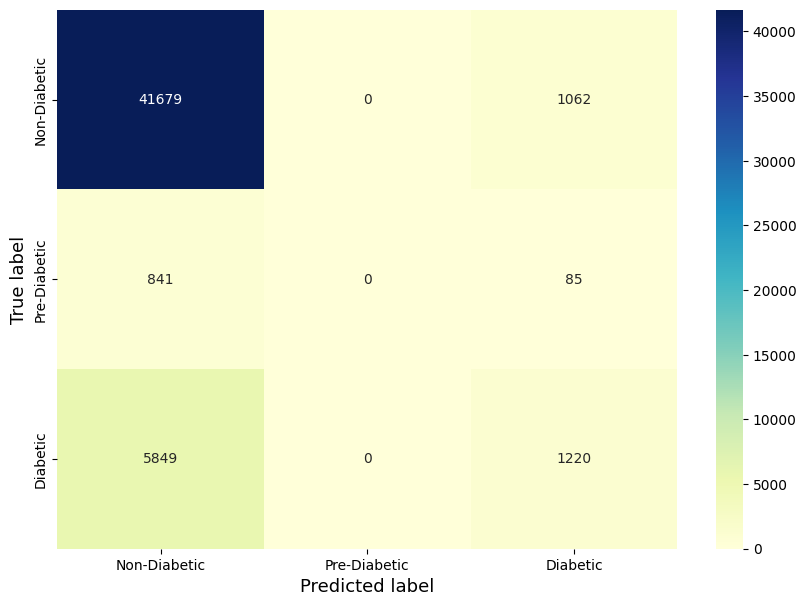

In [21]:
cm = confusion_matrix(y_test_logreg_012, y_pred_logreg_012)
cm_df = pd.DataFrame(cm, index = [i for i in ['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']], columns = [i for i in ['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']])
plt.figure(figsize = (10,7))
sn.heatmap(cm_df, cmap="YlGnBu", fmt='g', annot=True)
plt.xlabel('Predicted label',fontsize = 13)
plt.ylabel('True label',fontsize = 13)
plt.show()

### 2-Class Binary Split Dataset

In [22]:
y_test_logreg_binary, y_pred_logreg_binary, fpr_logreg_binary, tpr_logreg_binary, roc_auc_val_logreg_binary = logreg_classifier_binary_split_train_evaluate(train_data_file_binary_split, test_data_file_binary_split)

In [23]:
print(classification_report(y_test_logreg_binary, y_pred_logreg_binary, target_names=['Non-Diabetic', 'Diabetic']))

              precision    recall  f1-score   support

Non-Diabetic       0.76      0.73      0.74      7070
    Diabetic       0.74      0.76      0.75      7069

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139



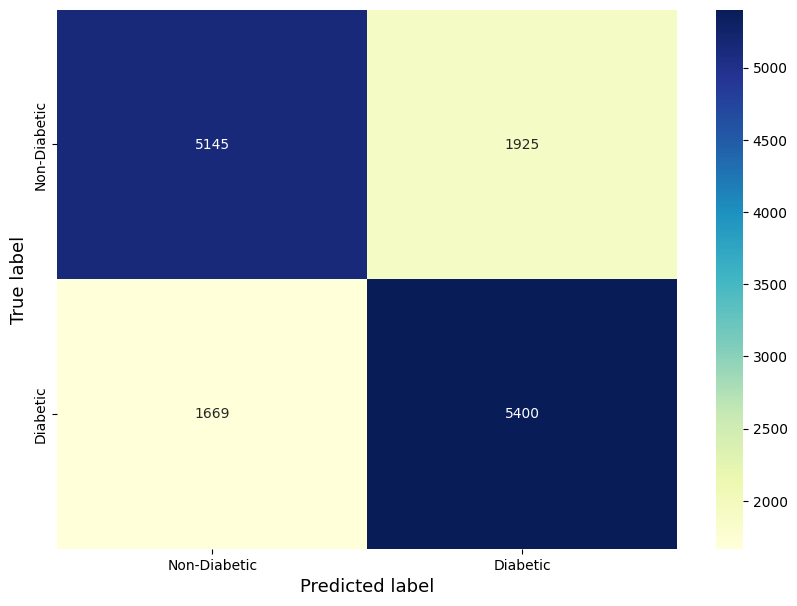

In [24]:
cm = confusion_matrix(y_test_logreg_binary, y_pred_logreg_binary)
cm_df = pd.DataFrame(cm, index = [i for i in ['Non-Diabetic', 'Diabetic']], columns = [i for i in ['Non-Diabetic', 'Diabetic']])
plt.figure(figsize = (10,7))
sn.heatmap(cm_df,  cmap="YlGnBu", fmt='g', annot=True)
plt.xlabel('Predicted label',fontsize = 13)
plt.ylabel('True label',fontsize = 13)
plt.show()

# SVM Evaluation

### 3 Class Diabetes Dataset

In [25]:
y_test_svm_012, y_pred_svm_012 = svm_classifier_012_load(train_data_file_012, test_data_file_012)

In [26]:
print(classification_report(y_test_svm_012, y_pred_svm_012, target_names=['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']))

              precision    recall  f1-score   support

Non-Diabetic       0.85      0.99      0.92     42741
Pre-Diabetic       0.00      0.00      0.00       926
    Diabetic       0.60      0.09      0.15      7069

    accuracy                           0.85     50736
   macro avg       0.48      0.36      0.36     50736
weighted avg       0.80      0.85      0.79     50736



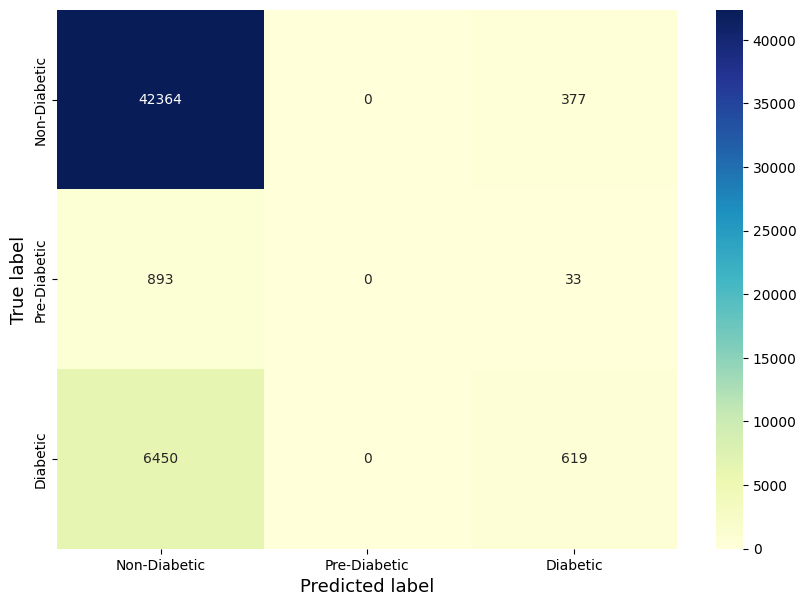

In [27]:
cm = confusion_matrix(y_test_svm_012, y_pred_svm_012)
cm_df = pd.DataFrame(cm, index = [i for i in ['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']], columns = [i for i in ['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']])
plt.figure(figsize = (10,7))
sn.heatmap(cm_df, cmap="YlGnBu", fmt='g', annot=True)
plt.xlabel('Predicted label',fontsize = 13)
plt.ylabel('True label',fontsize = 13)
plt.show()

### 2-Class Binary Split Dataset

In [28]:
y_test_svm_binary, y_pred_svm_binary, fpr_svm_binary, tpr_svm_binary, roc_auc_val_svm_binary = svm_classifier_binary_split_train_evaluate(train_data_file_binary_split, test_data_file_binary_split)

In [29]:
print(classification_report(y_test_svm_binary, y_pred_svm_binary, target_names=['Non-Diabetic', 'Diabetic']))

              precision    recall  f1-score   support

Non-Diabetic       0.78      0.69      0.74      7070
    Diabetic       0.72      0.80      0.76      7069

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139



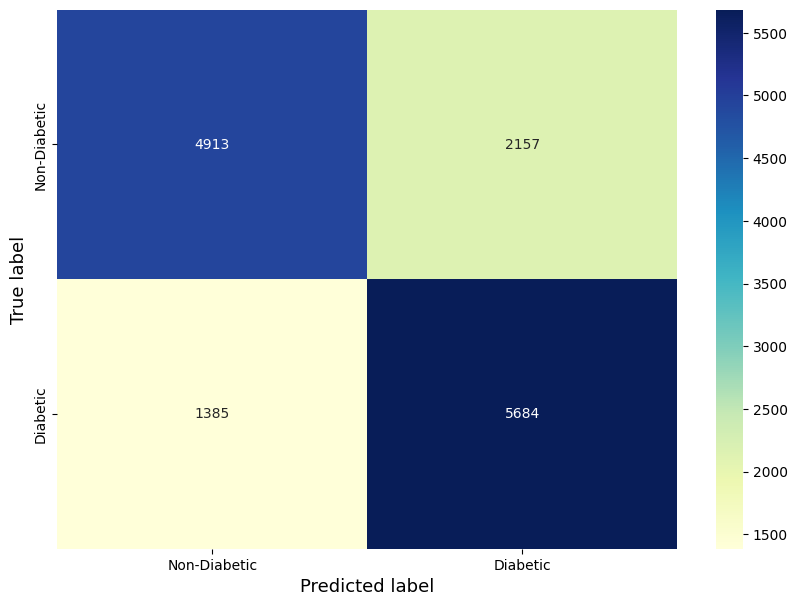

In [30]:
cm = confusion_matrix(y_test_svm_binary, y_pred_svm_binary)
cm_df = pd.DataFrame(cm, index = [i for i in ['Non-Diabetic', 'Diabetic']], columns = [i for i in ['Non-Diabetic', 'Diabetic']])
plt.figure(figsize = (10,7))
sn.heatmap(cm_df,  cmap="YlGnBu", fmt='g', annot=True)
plt.xlabel('Predicted label',fontsize = 13)
plt.ylabel('True label',fontsize = 13)
plt.show()

# MLP Evaluation

### 3 Class Diabetes Dataset

In [31]:
y_test_mlp_012, y_pred_mlp_012 = mlp_classifer_012_train_evaluate(train_data_file_012, test_data_file_012)

Iteration 1, loss = 0.41348346
Iteration 2, loss = 0.39798539
Iteration 3, loss = 0.39654522
Iteration 4, loss = 0.39568325
Iteration 5, loss = 0.39508681
Iteration 6, loss = 0.39467972
Iteration 7, loss = 0.39443761
Iteration 8, loss = 0.39406303
Iteration 9, loss = 0.39395846
Iteration 10, loss = 0.39366435
Iteration 11, loss = 0.39347873
Iteration 12, loss = 0.39343300
Iteration 13, loss = 0.39357893
Iteration 14, loss = 0.39312727
Iteration 15, loss = 0.39283409
Iteration 16, loss = 0.39311141
Iteration 17, loss = 0.39264126
Iteration 18, loss = 0.39269942
Iteration 19, loss = 0.39256689
Iteration 20, loss = 0.39236966
Iteration 21, loss = 0.39225361
Iteration 22, loss = 0.39235107
Iteration 23, loss = 0.39216709
Iteration 24, loss = 0.39215845
Iteration 25, loss = 0.39194621
Iteration 26, loss = 0.39187023
Iteration 27, loss = 0.39177857
Iteration 28, loss = 0.39181418
Iteration 29, loss = 0.39180822
Iteration 30, loss = 0.39176844


Printing the metrics

In [32]:
print(classification_report(y_test_mlp_012, y_pred_mlp_012, target_names=['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']))

              precision    recall  f1-score   support

Non-Diabetic       0.86      0.98      0.92     42741
Pre-Diabetic       0.00      0.00      0.00       926
    Diabetic       0.56      0.18      0.27      7069

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      0.81     50736



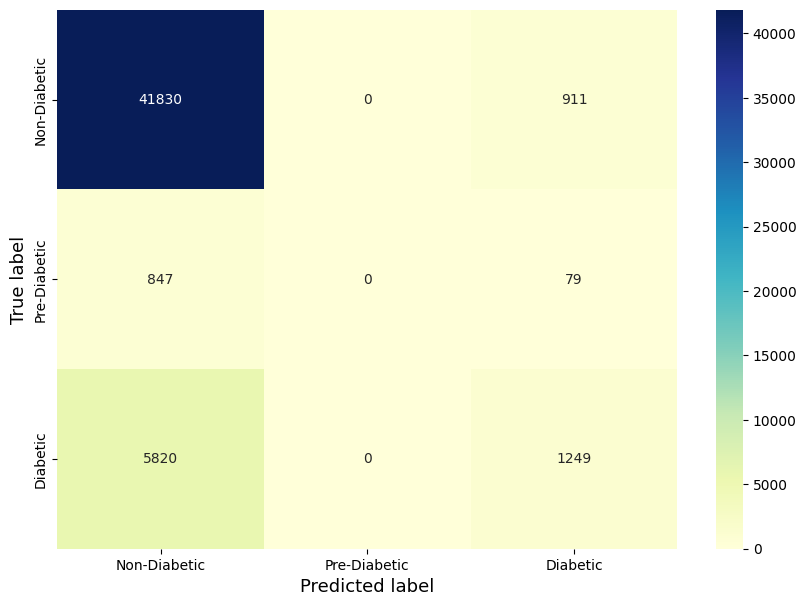

In [33]:
cm = confusion_matrix(y_test_mlp_012, y_pred_mlp_012)
cm_df = pd.DataFrame(cm, index = [i for i in ['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']], columns = [i for i in ['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']])
plt.figure(figsize = (10,7))
sn.heatmap(cm_df, cmap="YlGnBu", fmt='g', annot=True)
plt.xlabel('Predicted label',fontsize = 13)
plt.ylabel('True label',fontsize = 13)
plt.show()

### 2-Class Binary Split Dataset

In [34]:
y_test_mlp_binary, y_pred_mlp_binary, fpr_mlp_binary, tpr_mlp_binary, roc_auc_val_mlp_binary = mlp_classifer_binary_split_train_evaluate(train_data_file_binary_split, test_data_file_binary_split)

Iteration 1, loss = 0.52848930
Iteration 2, loss = 0.51332728
Iteration 3, loss = 0.51055742
Iteration 4, loss = 0.50879906
Iteration 5, loss = 0.50866677
Iteration 6, loss = 0.50696033
Iteration 7, loss = 0.50640731
Iteration 8, loss = 0.50700468
Iteration 9, loss = 0.50563678
Iteration 10, loss = 0.50552383
Iteration 11, loss = 0.50518642
Iteration 12, loss = 0.50453604
Iteration 13, loss = 0.50491888
Iteration 14, loss = 0.50491077
Iteration 15, loss = 0.50469685
Iteration 16, loss = 0.50359450
Iteration 17, loss = 0.50388794
Iteration 18, loss = 0.50348224
Iteration 19, loss = 0.50300684
Iteration 20, loss = 0.50361014
Iteration 21, loss = 0.50300293
Iteration 22, loss = 0.50267305
Iteration 23, loss = 0.50272556
Iteration 24, loss = 0.50303126
Iteration 25, loss = 0.50243603
Iteration 26, loss = 0.50255995
Iteration 27, loss = 0.50201412
Iteration 28, loss = 0.50264185
Iteration 29, loss = 0.50192347
Iteration 30, loss = 0.50149975


Printing the metrics

In [35]:
print(classification_report(y_test_mlp_binary, y_pred_mlp_binary, target_names=['Non-Diabetic', 'Diabetic']))

              precision    recall  f1-score   support

Non-Diabetic       0.75      0.76      0.75      7070
    Diabetic       0.75      0.74      0.75      7069

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139



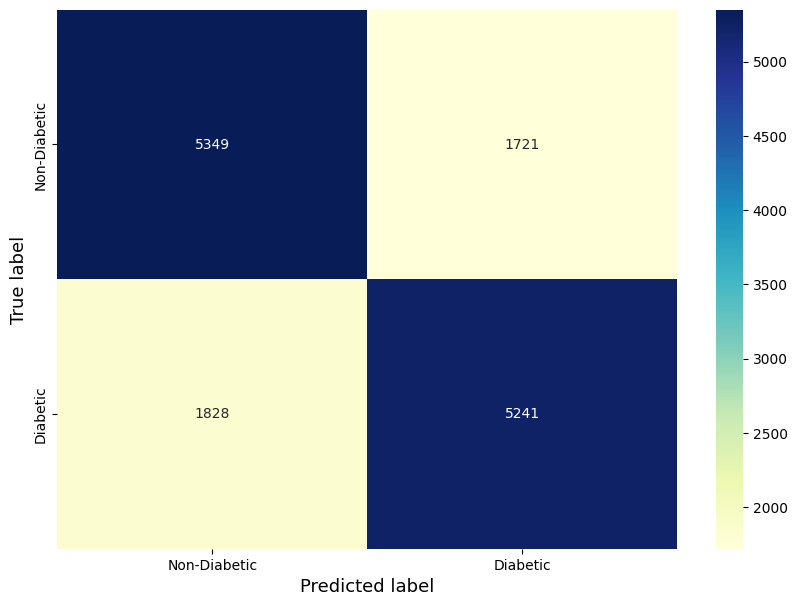

In [36]:
cm = confusion_matrix(y_test_mlp_binary, y_pred_mlp_binary)
cm_df = pd.DataFrame(cm, index = [i for i in ['Non-Diabetic', 'Diabetic']], columns = [i for i in ['Non-Diabetic', 'Diabetic']])
plt.figure(figsize = (10,7))
sn.heatmap(cm_df,  cmap="YlGnBu", fmt='g', annot=True)
plt.xlabel('Predicted label',fontsize = 13)
plt.ylabel('True label',fontsize = 13)
plt.show()

# XGBoost Evaluation

### 3 Class Diabetes Dataset

#### Full Features

In [37]:
y_test_xgboost_012_full, y_pred_xgboost_012_full = xgb_classifier_012_train_evaluate(train_data_file_012, test_data_file_012)

In [38]:
print(classification_report(y_test_xgboost_012_full, y_pred_xgboost_012_full, target_names=['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']))

              precision    recall  f1-score   support

Non-Diabetic       0.87      0.98      0.92     42741
Pre-Diabetic       0.00      0.00      0.00       926
    Diabetic       0.55      0.20      0.29      7069

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.81      0.85      0.81     50736



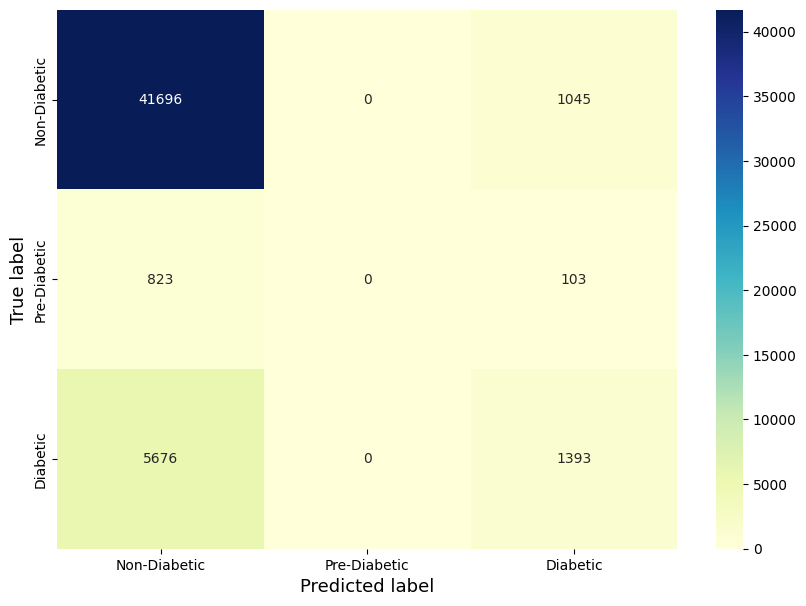

In [39]:
cm = confusion_matrix(y_test_xgboost_012_full, y_pred_xgboost_012_full)
cm_df = pd.DataFrame(cm, index = [i for i in ['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']], columns = [i for i in ['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']])
plt.figure(figsize = (10,7))
sn.heatmap(cm_df, cmap="YlGnBu", fmt='g', annot=True)
plt.xlabel('Predicted label',fontsize = 13)
plt.ylabel('True label',fontsize = 13)
plt.show()

#### Top 5 Features

In [40]:
y_test_xgboost_012_top, y_pred_xgboost_012_top = xgb_classifier_ranked_features_012_train_evaluate(train_data_file_012, test_data_file_012)

In [41]:
print(classification_report(y_test_xgboost_012_top, y_pred_xgboost_012_top, target_names=['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']))

              precision    recall  f1-score   support

Non-Diabetic       0.86      0.98      0.92     42741
Pre-Diabetic       0.00      0.00      0.00       926
    Diabetic       0.55      0.16      0.25      7069

    accuracy                           0.85     50736
   macro avg       0.47      0.38      0.39     50736
weighted avg       0.80      0.85      0.81     50736



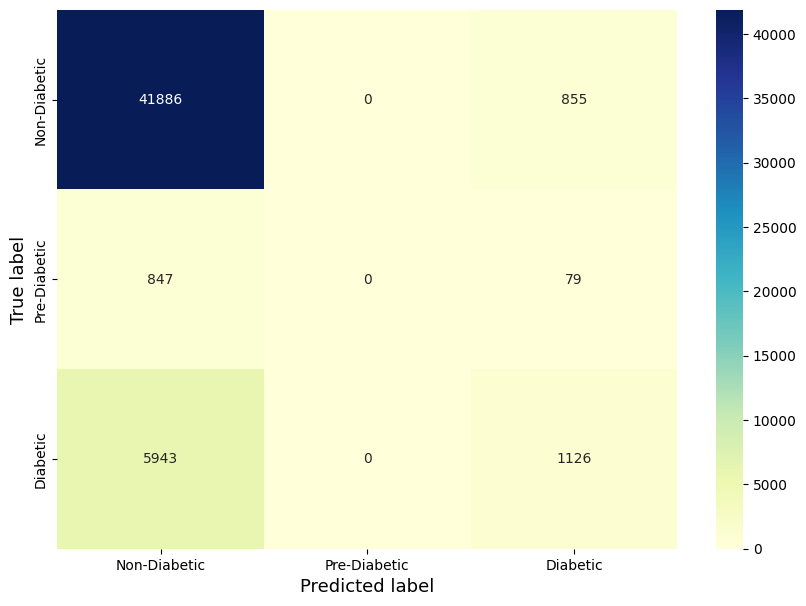

In [42]:
cm = confusion_matrix(y_test_xgboost_012_top, y_pred_xgboost_012_top)
cm_df = pd.DataFrame(cm, index = [i for i in ['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']], columns = [i for i in ['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']])
plt.figure(figsize = (10,7))
sn.heatmap(cm_df, cmap="YlGnBu", fmt='g', annot=True)
plt.xlabel('Predicted label',fontsize = 13)
plt.ylabel('True label',fontsize = 13)
plt.show()

### 2-Class Binary Split Dataset

#### Full Features

In [43]:
y_test_xgboost_binary_full, y_pred_xgboost_binary_full, fpr_xgboost_binary_full, tpr_xgboost_binary_full, roc_auc_val_xgboost_binary_full = xgb_classifer_binary_split_train_evaluate(train_data_file_binary_split, test_data_file_binary_split)

In [44]:
print(classification_report(y_test_xgboost_binary_full, y_pred_xgboost_binary_full, target_names=['Non-Diabetic', 'Diabetic']))

              precision    recall  f1-score   support

Non-Diabetic       0.78      0.71      0.74      7070
    Diabetic       0.73      0.80      0.76      7069

    accuracy                           0.75     14139
   macro avg       0.76      0.75      0.75     14139
weighted avg       0.76      0.75      0.75     14139



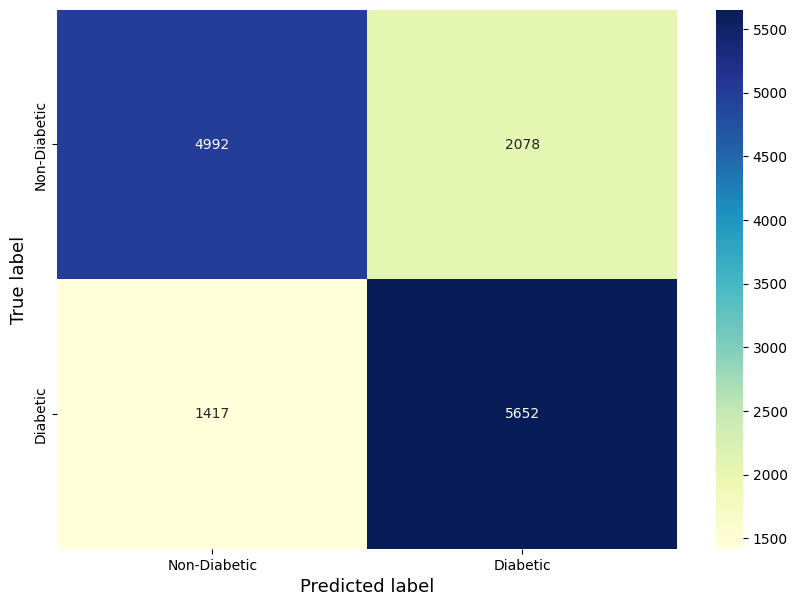

In [45]:
cm = confusion_matrix(y_test_xgboost_binary_full, y_pred_xgboost_binary_full)
cm_df = pd.DataFrame(cm, index = [i for i in ['Non-Diabetic', 'Diabetic']], columns = [i for i in ['Non-Diabetic', 'Diabetic']])
plt.figure(figsize = (10,7))
sn.heatmap(cm_df,  cmap="YlGnBu", fmt='g', annot=True)
plt.xlabel('Predicted label',fontsize = 13)
plt.ylabel('True label',fontsize = 13)
plt.show()

#### Top 5 Features

In [46]:
y_test_xgboost_binary_top, y_pred_xgboost_binary_top, fpr_xgboost_binary_top, tpr_xgboost_binary_top, roc_auc_val_xgboost_binary_top = xgb_classifer_ranked_features_binary_split_train_evaluate(train_data_file_binary_split, test_data_file_binary_split)

In [47]:
print(classification_report(y_test_xgboost_binary_top, y_pred_xgboost_binary_top, target_names=['Non-Diabetic', 'Diabetic']))

              precision    recall  f1-score   support

Non-Diabetic       0.77      0.70      0.73      7070
    Diabetic       0.72      0.79      0.76      7069

    accuracy                           0.74     14139
   macro avg       0.75      0.74      0.74     14139
weighted avg       0.75      0.74      0.74     14139



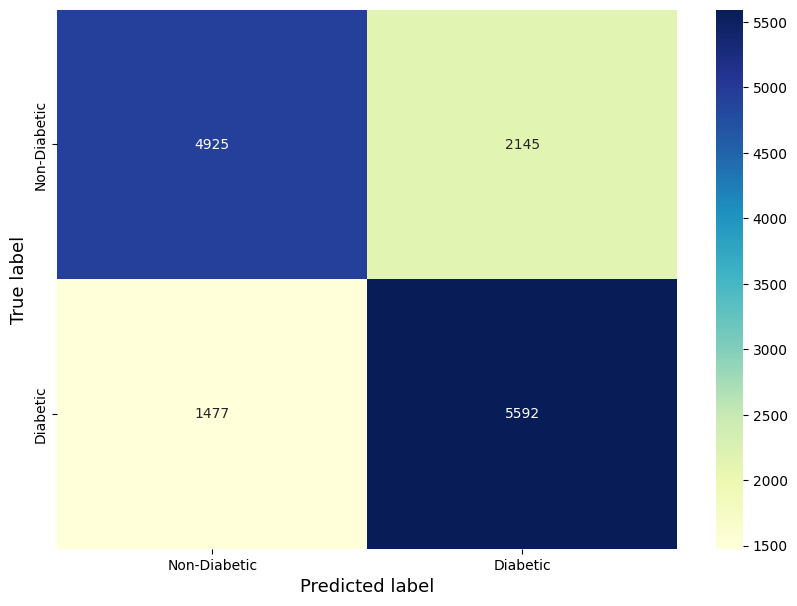

In [48]:
cm = confusion_matrix(y_test_xgboost_binary_top, y_pred_xgboost_binary_top)
cm_df = pd.DataFrame(cm, index = [i for i in ['Non-Diabetic', 'Diabetic']], columns = [i for i in ['Non-Diabetic', 'Diabetic']])
plt.figure(figsize = (10,7))
sn.heatmap(cm_df,  cmap="YlGnBu", fmt='g', annot=True)
plt.xlabel('Predicted label',fontsize = 13)
plt.ylabel('True label',fontsize = 13)
plt.show()

# Random Forest Evaluation

### 3 Class Diabetes Dataset

#### Full Features

In [49]:
y_test_rf_012_full, y_pred_rf_012_full = random_forest_012_train_evaluate(train_data_file_012, test_data_file_012)

In [50]:
print(classification_report(y_test_rf_012_full, y_pred_rf_012_full, target_names=['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']))

              precision    recall  f1-score   support

Non-Diabetic       0.86      0.97      0.91     42741
Pre-Diabetic       0.00      0.00      0.00       926
    Diabetic       0.48      0.20      0.28      7069

    accuracy                           0.84     50736
   macro avg       0.45      0.39      0.40     50736
weighted avg       0.80      0.84      0.81     50736



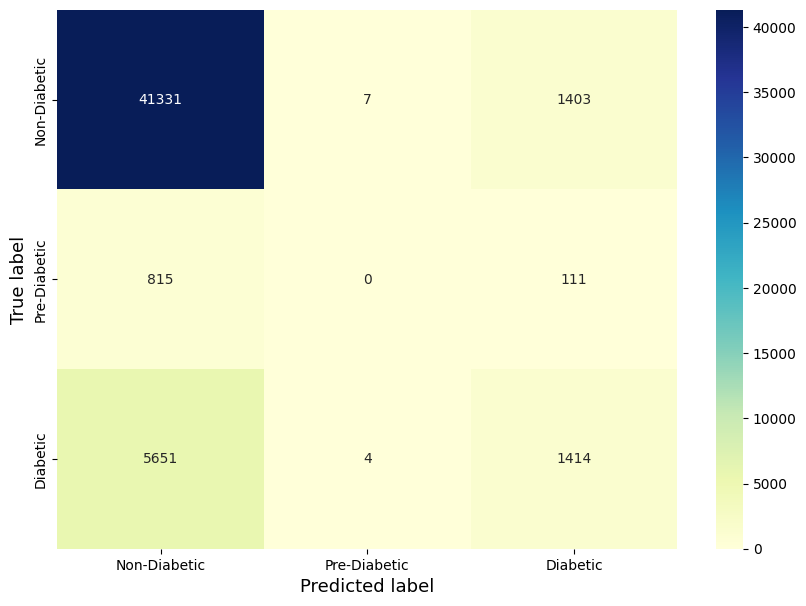

In [51]:
cm = confusion_matrix(y_test_rf_012_full, y_pred_rf_012_full)
cm_df = pd.DataFrame(cm, index = [i for i in ['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']], columns = [i for i in ['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']])
plt.figure(figsize = (10,7))
sn.heatmap(cm_df, cmap="YlGnBu", fmt='g', annot=True)
plt.xlabel('Predicted label',fontsize = 13)
plt.ylabel('True label',fontsize = 13)
plt.show()

#### Top 5 Features

In [52]:
y_test_rf_012_top, y_pred_rf_012_top = random_forest_012_train_evaluate_top5(train_data_file_012, test_data_file_012)

In [53]:
print(classification_report(y_test_rf_012_top, y_pred_rf_012_top, target_names=['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']))

              precision    recall  f1-score   support

Non-Diabetic       0.86      0.95      0.91     42741
Pre-Diabetic       0.01      0.00      0.00       926
    Diabetic       0.39      0.19      0.25      7069

    accuracy                           0.83     50736
   macro avg       0.42      0.38      0.39     50736
weighted avg       0.78      0.83      0.80     50736



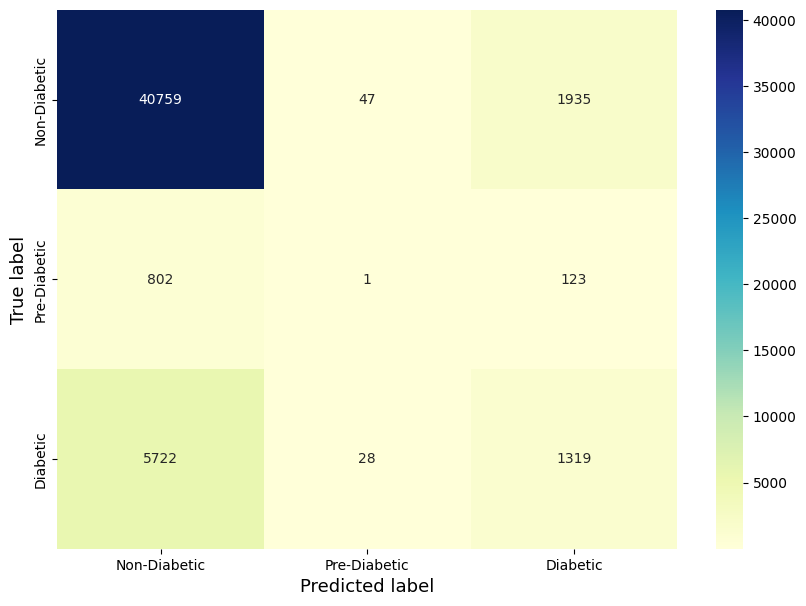

In [54]:
cm = confusion_matrix(y_test_rf_012_top, y_pred_rf_012_top)
cm_df = pd.DataFrame(cm, index = [i for i in ['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']], columns = [i for i in ['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']])
plt.figure(figsize = (10,7))
sn.heatmap(cm_df, cmap="YlGnBu", fmt='g', annot=True)
plt.xlabel('Predicted label',fontsize = 13)
plt.ylabel('True label',fontsize = 13)
plt.show()

### 2-Class Binary Split Dataset

#### Full Features

In [55]:
y_test_rf_binary_full, y_pred_rf_binary_full, fpr_rf_binary_full, tpr_rf_binary_full, roc_auc_val_rf_binary_full = random_forest_binary_split_train_evaluate(train_data_file_binary_split, test_data_file_binary_split)

In [56]:
print(classification_report(y_test_rf_binary_full, y_pred_rf_binary_full, target_names=['Non-Diabetic', 'Diabetic']))

              precision    recall  f1-score   support

Non-Diabetic       0.77      0.70      0.73      7070
    Diabetic       0.73      0.79      0.76      7069

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139



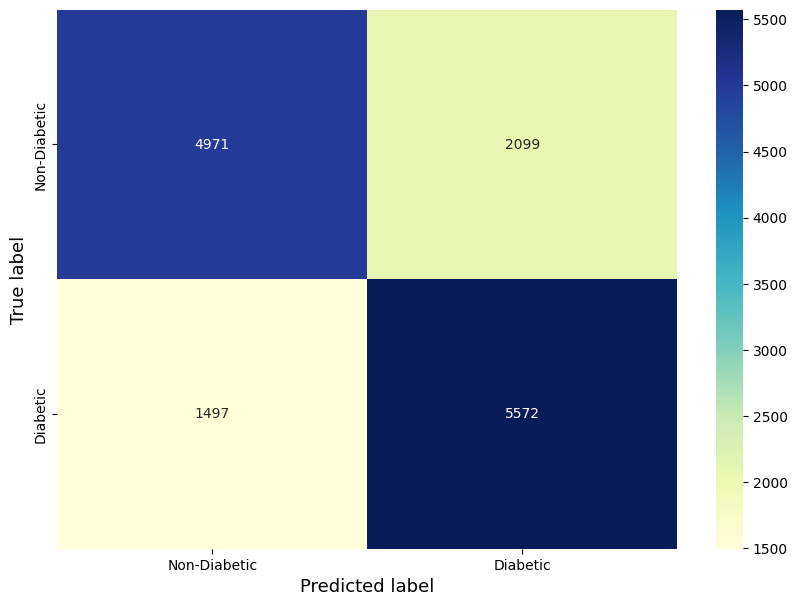

In [57]:
cm = confusion_matrix(y_test_rf_binary_full, y_pred_rf_binary_full)
cm_df = pd.DataFrame(cm, index = [i for i in ['Non-Diabetic', 'Diabetic']], columns = [i for i in ['Non-Diabetic', 'Diabetic']])
plt.figure(figsize = (10,7))
sn.heatmap(cm_df,  cmap="YlGnBu", fmt='g', annot=True)
plt.xlabel('Predicted label',fontsize = 13)
plt.ylabel('True label',fontsize = 13)
plt.show()

#### Top 5 Features

In [58]:
y_test_rf_binary_top, y_pred_rf_binary_top, fpr_rf_binary_top, tpr_rf_binary_top, roc_auc_val_rf_binary_top = random_forest_binary_split_train_evaluate_top5(train_data_file_binary_split, test_data_file_binary_split)

In [59]:
print(classification_report(y_test_rf_binary_top, y_pred_rf_binary_top, target_names=['Non-Diabetic', 'Diabetic']))

              precision    recall  f1-score   support

Non-Diabetic       0.74      0.69      0.71      7070
    Diabetic       0.71      0.76      0.73      7069

    accuracy                           0.72     14139
   macro avg       0.72      0.72      0.72     14139
weighted avg       0.72      0.72      0.72     14139



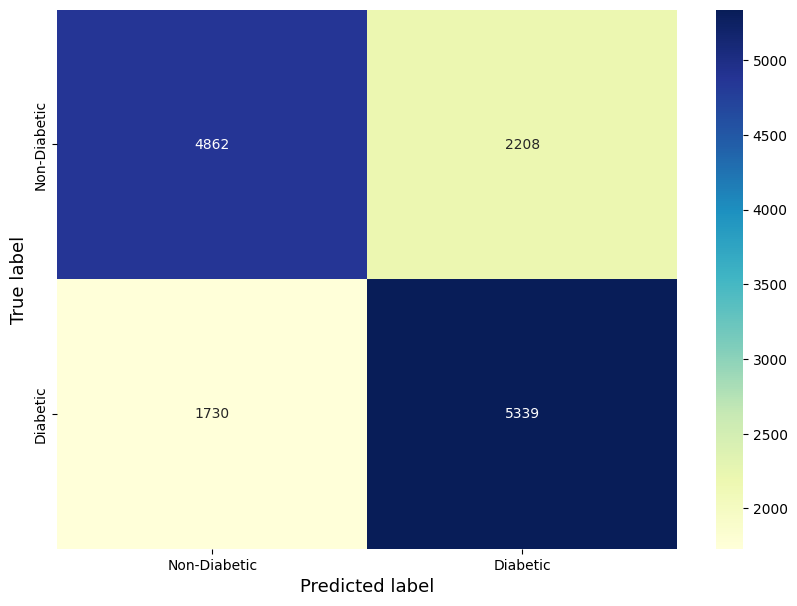

In [60]:
cm = confusion_matrix(y_test_rf_binary_top, y_pred_rf_binary_top)
cm_df = pd.DataFrame(cm, index = [i for i in ['Non-Diabetic', 'Diabetic']], columns = [i for i in ['Non-Diabetic', 'Diabetic']])
plt.figure(figsize = (10,7))
sn.heatmap(cm_df,  cmap="YlGnBu", fmt='g', annot=True)
plt.xlabel('Predicted label',fontsize = 13)
plt.ylabel('True label',fontsize = 13)
plt.show()

# Displaying the combined ROC AUC Curve

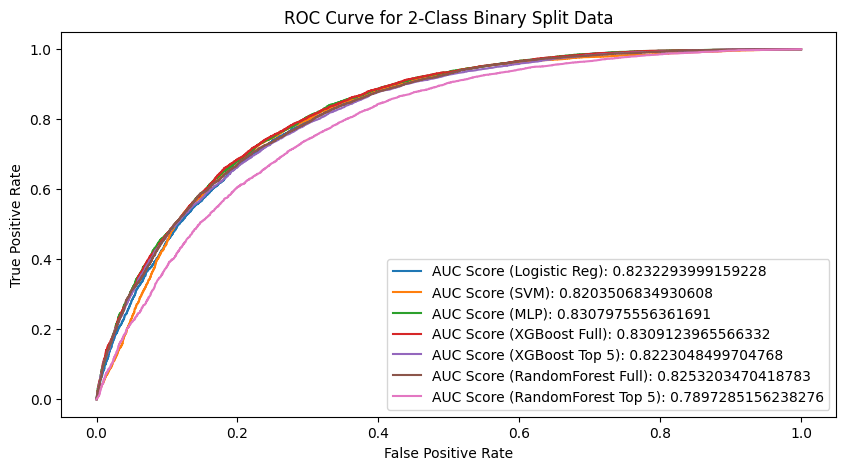

In [62]:
plt.figure(figsize=(10,5))
plt.plot(fpr_logreg_binary, tpr_logreg_binary, label=f"AUC Score (Logistic Reg): {roc_auc_val_logreg_binary}")
plt.plot(fpr_svm_binary, tpr_svm_binary, label=f"AUC Score (SVM): {roc_auc_val_svm_binary}")
plt.plot(fpr_mlp_binary, tpr_mlp_binary, label=f"AUC Score (MLP): {roc_auc_val_mlp_binary}")
plt.plot(fpr_xgboost_binary_full, tpr_xgboost_binary_full, label=f"AUC Score (XGBoost Full): {roc_auc_val_xgboost_binary_full}")
plt.plot(fpr_xgboost_binary_top, tpr_xgboost_binary_top, label=f"AUC Score (XGBoost Top 5): {roc_auc_val_xgboost_binary_top}")
plt.plot(fpr_rf_binary_full, tpr_rf_binary_full, label=f"AUC Score (RandomForest Full): {roc_auc_val_rf_binary_full}")
plt.plot(fpr_rf_binary_top, tpr_rf_binary_top, label=f"AUC Score (RandomForest Top 5): {roc_auc_val_rf_binary_top}")
plt.title('ROC Curve for 2-Class Binary Split Data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()